# 数据信息介绍
每个数据样本对应一个已完成的行程。它总共包含9个属性，描述如下：
```
这次旅行的总旅行时间（本次比赛的预测目标）定义为（点数-1）* 15 秒。例如，POLYLINE 中有 101 个数据点的行程的长度为 (101-1) * 15 = 1500 秒。某些行程在 POLYLINE 中缺少数据点，由 MISSING_DATA 列指示。

TRIP_ID：（字符串）每一次行程都有唯一的TRIP_ID标号，以用来区分

CALL_TYPE：（字符）由A、B、C三类标识来区分打车形式
    A: 由中心调度
    B: 在特定站点直接打车
    C: 其他类型

ORIGIN_CALL：（整型）用来唯一标识此次行程消费者的电话号码

ORIGIN_STAND：（整型）唯一标识出租车站点

TAXI_ID：（整型）每一次行程中出租车司机的唯一标识

TIMESTAMP：（整型）Unix 时间戳，标识行程的开始

DAYTYPE：（字符）由A、B、C三类标识区别出租车行程的日期类型
    A: 其他
    B: 假期
    C: 假期前一天

MISSING_DATA：（布尔值）当POLYLINE中有一个或多个坐标丢失时，值为true，否则为false

POLYLINE：（字符串）由坐标序列组成，起始坐标为出发点，结尾坐标为目的地。行程中每隔15秒记录一次坐标信息
```



# 调库

In [253]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import squarify as sq
from pyecharts.charts import Bar
from pyecharts.charts import Pie
from pyecharts.charts import Line
from pyecharts import options as opts

sns.set(color_codes=True)

%matplotlib inline

# 数据导入

In [3]:
source = pd.read_csv("../../sources/taxi/train.csv", sep=",", low_memory=False)
source.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


# 不包含行驶路线的数据分析
## 去除行驶路线数据及错误数据

In [4]:
no_poly_source = source.loc[:, source.columns != 'POLYLINE']
#no_poly_source.head()
miss_false_no_poly_source = no_poly_source[no_poly_source.MISSING_DATA == False]
miss_false_no_poly_source.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False


## 处理时间戳
将timestamp格式转换为需要统计的时间属性
>注意葡萄牙当地时间为+0时区，因此使用`utcfromtimestamp`函数来处理

In [5]:
new_source = miss_false_no_poly_source.copy()
new_source['WEEK_DAY'] = new_source.TIMESTAMP.apply(lambda x: dt.datetime.utcfromtimestamp(x).weekday())
new_source['YEAR'] = new_source.TIMESTAMP.apply(lambda x: dt.datetime.utcfromtimestamp(x).year)
new_source['MONTH'] = new_source.TIMESTAMP.apply(lambda x: dt.datetime.utcfromtimestamp(x).month)
new_source['MONTH_DAY'] = new_source.TIMESTAMP.apply(lambda x: dt.datetime.utcfromtimestamp(x).day)
new_source['HOUR'] = new_source.TIMESTAMP.apply(lambda x: dt.datetime.utcfromtimestamp(x).hour)
new_source['DATE'] = new_source.TIMESTAMP.apply(lambda x: dt.datetime.utcfromtimestamp(x).date().isoformat())
new_source['DATE_DATE'] = new_source.TIMESTAMP.apply(lambda x: dt.datetime.utcfromtimestamp(x).date())
new_source.tail()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,WEEK_DAY,YEAR,MONTH,MONTH_DAY,HOUR,DATE,DATE_DATE
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,0,2014,6,30,23,2014-06-30,2014-06-30
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,0,2014,6,30,23,2014-06-30,2014-06-30
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,4,2014,1,3,10,2014-01-03,2014-01-03
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,0,2014,6,30,15,2014-06-30,2014-06-30
1710669,1404157147620000079,B,NaN,34.0,20000079,1404157147,A,False,0,2014,6,30,19,2014-06-30,2014-06-30


## 导出处理后数据

In [6]:
new_source.to_csv('newSource/miss_false_no_poly_new_source.csv')

## 数据概览
### 数据年份统计

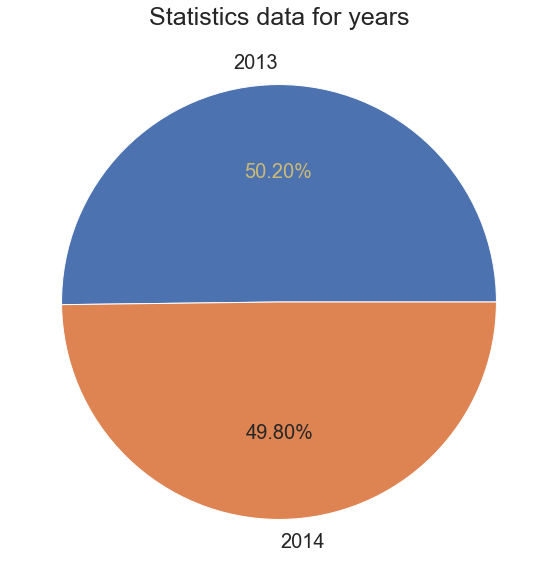

In [7]:
plt.figure(figsize=(10,10))
patches, texts, autotexts = plt.pie(new_source.YEAR.value_counts().values
        , labels=new_source.YEAR.value_counts().keys()
        , autopct='%1.2f%%')

for t in texts:
    t.set_fontsize(20)
for t in autotexts:
    t.set_fontsize(20)
autotexts[0].set_color('y')

plt.title('Statistics data for years', size = 25)

plt.savefig('../../images/DVPPT/1year.png')
plt.show()

In [8]:
keys_year = new_source['YEAR'].value_counts().keys().tolist()
# keys_year
values_year = new_source['YEAR'].value_counts().values.tolist()
# values_year

pie = (
    Pie()
    .add(
        "",
        # zip函数两个部分组合在一起list(zip(x,y))-----> [(x,y)]
        [list(z) for z in zip(keys_year, values_year)],
        rosetype="radius"  # 玫瑰图
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="数据年份统计"))  # 标题
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))  # 数据标签设置
)

pie.render("../../html/DVPPT/1year.html")
pie.render_notebook()

可以看到2013年数据与2014年数据量基本相等。

### 每月行程数统计


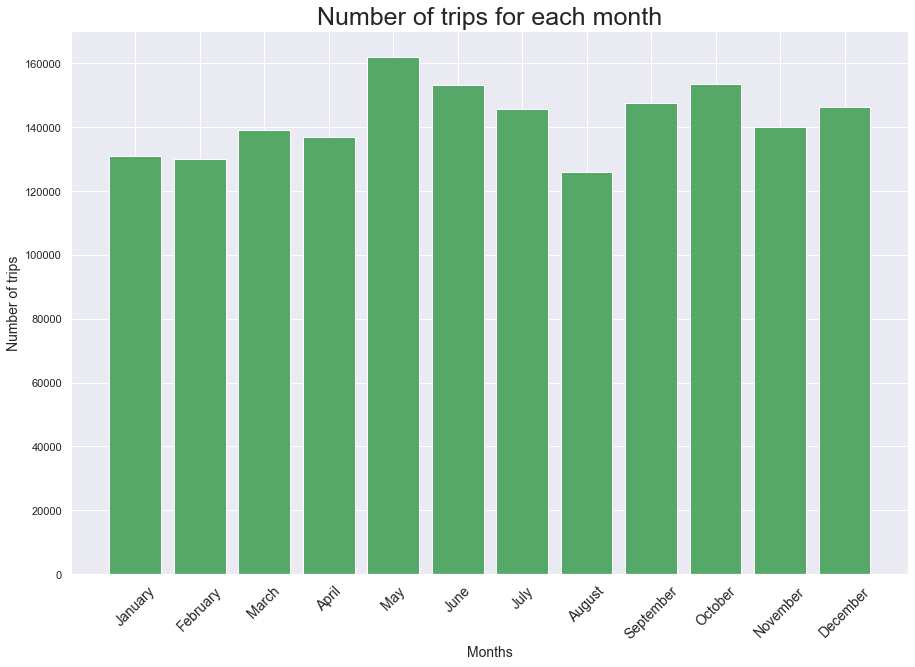

In [9]:
keys_month = np.arange(1,13)
values_month = ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_names = dict(zip(keys_month,values_month))

plt.figure(figsize=(15,10))
my_colors = 'g'
ax = plt.bar(new_source.MONTH.value_counts().keys()
        , new_source.MONTH.value_counts().values
        , color = my_colors)
plt.xticks(new_source.MONTH.value_counts().keys()
        , new_source.MONTH.map(month_names).value_counts().keys()
        , rotation = 45
        , size = 14)
plt.xlabel('Months', size = 14)
plt.ylabel('Number of trips', size = 14)
plt.title('Number of trips for each month', size = 25)

plt.savefig('../../images/DVPPT/2month.png')
plt.show()

In [10]:
pair_month = [list(z) for z in zip((new_source.MONTH.value_counts().keys()-1).tolist(),
                                   new_source.MONTH.value_counts().values.tolist())]

bar = (
    Bar()
        .add_xaxis(['1月','2月','3月','4月','5月','6月','7月','8月','9月','10月','11月','12月'])
        .add_yaxis("", pair_month)
        .set_global_opts(title_opts=opts.TitleOpts(title="每月行程数统计"),
                         xaxis_opts=opts.AxisOpts(name="月份",
                                                  name_location='middle',
                                                  name_gap=30)
                        ,yaxis_opts=opts.AxisOpts(name='行程数',
                                                  name_location='middle',
                                                  name_gap=60))
        .set_colors("#55a868")
)

bar.render("../../html/DVPPT/2month.html")
bar.render_notebook()

可以看到在5、10月打车人数较多，夏天、冬天时打车人数相对最少。

### 每小时行程数统计
#### 柱状图

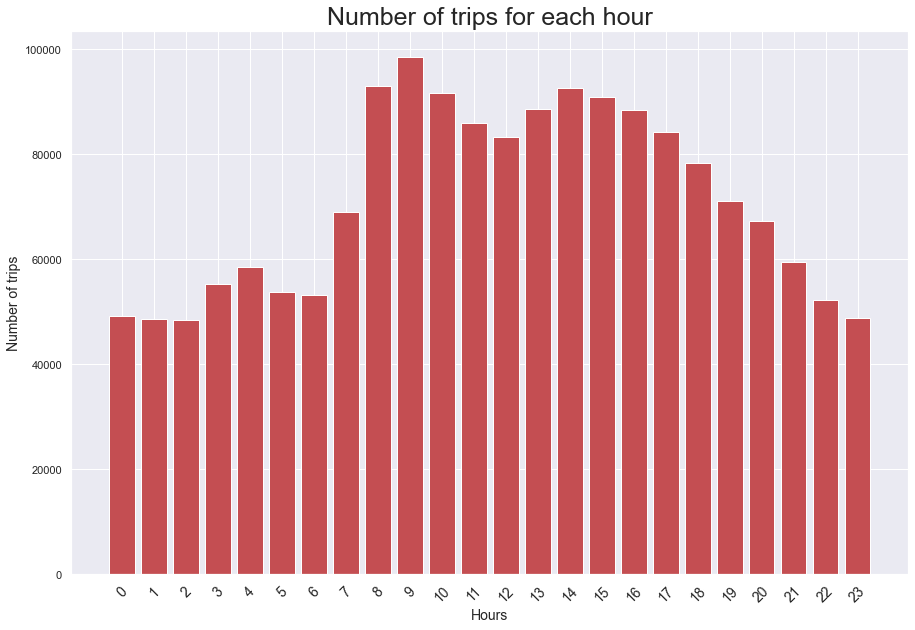

In [11]:
plt.figure(figsize=(15,10))
my_colors = 'r'

ax = plt.bar(new_source.HOUR.value_counts().keys()
             , new_source.HOUR.value_counts().values
             , color = my_colors)

plt.xticks(new_source.HOUR.value_counts().keys()
           , new_source.HOUR.value_counts().keys()
           , rotation = 45
           , size = 14)
plt.xlabel('Hours', size = 14)
plt.ylabel('Number of trips', size = 14)
plt.title('Number of trips for each hour', size = 25)

plt.savefig('../../images/DVPPT/3hour1.png')
plt.show()

In [12]:
pair_hours = [list(z) for z in zip(new_source.HOUR.value_counts().keys().tolist(),
                                   new_source.HOUR.value_counts().values.tolist())]

bar = (
    Bar()
        .add_xaxis(list(range(24)))
        .add_yaxis("", pair_hours)
        .set_global_opts(title_opts=opts.TitleOpts(title="每小时打车总数统计"),
                         xaxis_opts=opts.AxisOpts(name="小时数",
                                                  name_location='middle',
                                                  name_gap=30)
                        ,yaxis_opts=opts.AxisOpts(name='行程数',
                                                  name_location='middle',
                                                  name_gap=60))
        .set_colors("#c44e52")
)

bar.render("../../html/DVPPT/3hour1.html")
bar.render_notebook()

为了更清晰地看到一日内行程数变化，于是又制作了折线图。

#### 折线图

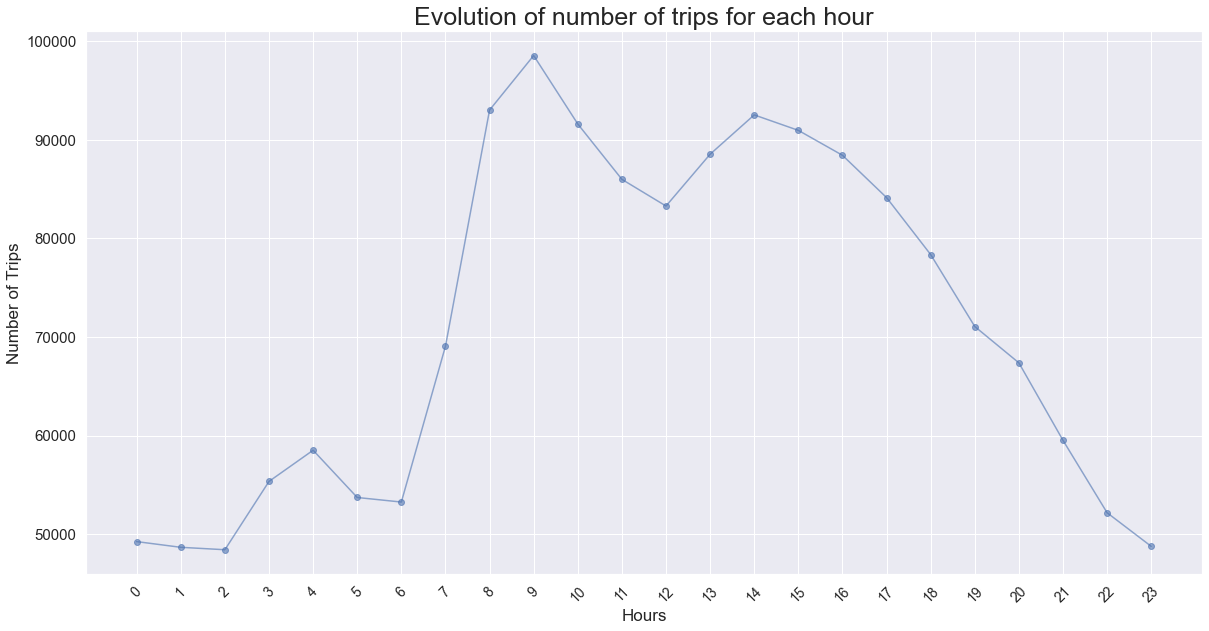

In [13]:
hour_plot = pd.DataFrame({
    'value': new_source.HOUR.value_counts().values
    , 'hour': new_source.HOUR.value_counts().keys()})
#time_plot.set_index('date', inplace=True)
hour_plot = hour_plot.set_index('hour')['value']
hour_plot.sort_index(inplace=True)
hour_plot.keys().astype("datetime64[ns]")

# Plotting
plt.figure(figsize=(20,10))
plt.rc('font', size=25)          # controls default text sizes
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

plt.xticks(new_source.HOUR.value_counts().keys()
           , new_source.HOUR.value_counts().keys()
           , rotation = 45
           , size = 14)

plt.xlabel('Hours')
plt.ylabel('Number of Trips')
plt.title('Evolution of number of trips for each hour')

plt.plot_date(hour_plot.keys(), hour_plot.values, 'bo-', alpha=0.6)

plt.savefig('../../images/DVPPT/4hour2.png')
plt.show();

In [14]:
pair_hours = [list(z) for z in zip(new_source.HOUR.value_counts().keys().tolist(),
                                   new_source.HOUR.value_counts().values.tolist())]
sorted_pair_hours = pd.DataFrame(pair_hours).sort_values(by=[0]).to_numpy().tolist()

line=(
    Line()
    .add_xaxis(list(range(24)))
    .add_yaxis('', [i[1] for i in sorted_pair_hours])
    .set_global_opts(title_opts=opts.TitleOpts(title="每小时打车总数统计"),
                     xaxis_opts=opts.AxisOpts(name="小时数",
                                              name_location='middle',
                                              name_gap=30)
                     ,yaxis_opts=opts.AxisOpts(name='行程数',
                                               name_location='middle',
                                               name_gap=60))
    .set_colors("#6888bb")
)

line.render("../../html/DVPPT/4hour2.html")
line.render_notebook()

可以明显看到早上的8、9、10点是打车高峰期，下午14点又是一个小高峰；凌晨是打车低谷期，而凌晨4点是低谷期中的一个小高峰。

### 行程类型占比统计

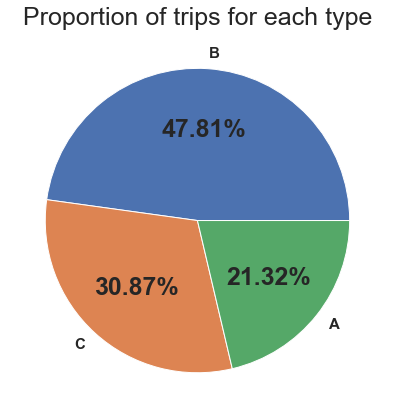

In [36]:
plt.figure(figsize=(7,7))
plt.rc('font', size=25)          # controls default text sizes
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.pie(new_source.CALL_TYPE.value_counts().values
        , labels=new_source.CALL_TYPE.value_counts().keys()
        , autopct='%1.2f%%')
plt.title('Proportion of trips for each type')

plt.savefig('../../images/DVPPT/5type.png')
plt.show()

In [240]:
keys_year = new_source['CALL_TYPE'].value_counts().keys().tolist()
# keys_year
values_year = new_source['CALL_TYPE'].value_counts().values.tolist()
# values_year

pie = (
    Pie()
    .add(
        "",
        # zip函数两个部分组合在一起list(zip(x,y))-----> [(x,y)]
        [list(z) for z in zip(keys_year, values_year)],
        radius=["30%", "60%"], rosetype="radius"  # 玫瑰图
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="打车类型占比统计"))  # 标题
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))  # 数据标签设置
)

pie.render("../../html/DVPPT/5type.html")
pie.render_notebook()

可以看到B类（在特定站点直接打车）的人数最多，约占一半

## 数据分析
### 一周内平均每日行程数比较

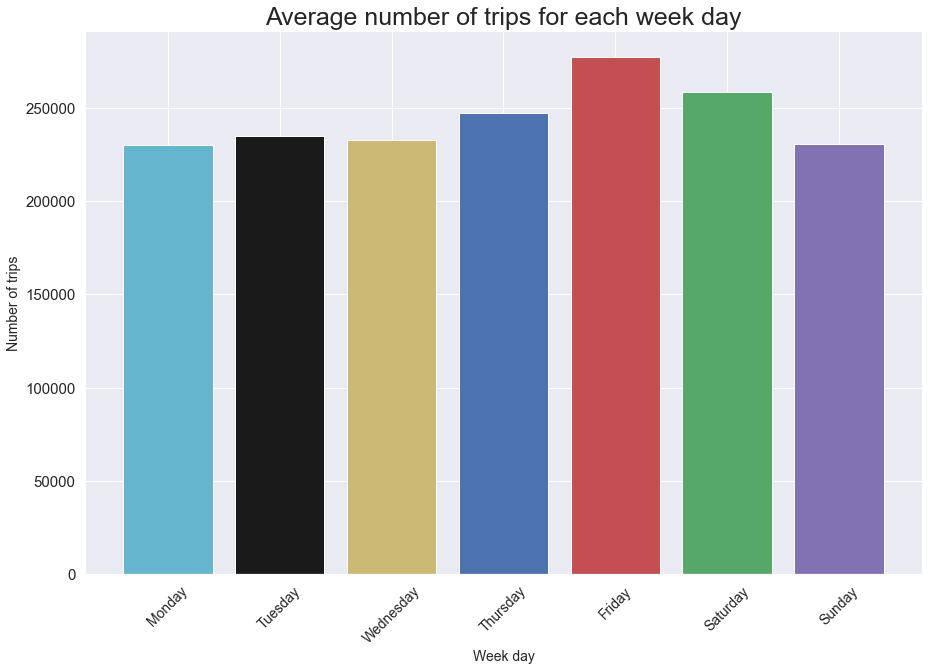

In [17]:
keys_week = np.arange(0,7)
values_week = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_days_names = dict(zip(keys_week,values_week))

plt.figure(figsize=(15,10))
my_colors = 'r','g','b','k','y','m','c'

ax = plt.bar(new_source.WEEK_DAY.value_counts().keys()
             , new_source.WEEK_DAY.map(week_days_names).value_counts().values
             , color = my_colors)

plt.xticks(new_source.WEEK_DAY.value_counts().keys()
           , new_source.WEEK_DAY.map(week_days_names).value_counts().keys()
           , rotation = 45
           , size = 14)
plt.xlabel('Week day', size = 14)
plt.ylabel('Number of trips', size = 14)
plt.title('Average number of trips for each week day')

plt.savefig('../../images/DVPPT/6average_week_day.png')
plt.show()

In [18]:
pair_weekday = [list(z) for z in zip((new_source.WEEK_DAY.value_counts().keys()).tolist(),
                                   new_source.WEEK_DAY.value_counts().values.tolist())]
sorted_pair_weekday = pd.DataFrame(pair_weekday).sort_values(by=[0]).to_numpy().tolist()

bar = (
    Bar()
        .add_xaxis(["周一","周二","周三","周四","周五","周六","周日"])
        .add_yaxis("", sorted_pair_weekday)
        .set_global_opts(title_opts=opts.TitleOpts(title="一周内平均每天打车次数比较"),
                         xaxis_opts=opts.AxisOpts(name="一日",
                                                  name_location='middle',
                                                  name_gap=30)
                        ,yaxis_opts=opts.AxisOpts(name='行程数',
                                                  name_location='middle',
                                                  name_gap=60))
        .set_colors("#7567a3")
)

bar.render("../../html/DVPPT/6average_week_day.html")
bar.render_notebook()

可以看到周五打车人数最多

### 不同类型在一周内的平均行程数比较
#### 一周内类型统计

In [19]:
call_type_df = new_source[['TRIP_ID','CALL_TYPE','WEEK_DAY']]
call_type_df = call_type_df.groupby(['WEEK_DAY','CALL_TYPE']).count()
unstack_call_type_df = call_type_df.unstack()
unstack_call_type_df

TRIP_ID               
CALL_TYPE       A       B      C
WEEK_DAY                        
0           54049  117904  57995
1           53381  117174  64176
2           52733  116447  63436
3           54567  123204  69254
4           61663  133288  82360
5           49694  112710  96230
6           38682   97151  94562

#### 导出一周内类型统计

In [20]:
unstack_call_type_df.to_csv('newSource/unstack_call_type_df.csv')

#### 堆叠柱状图

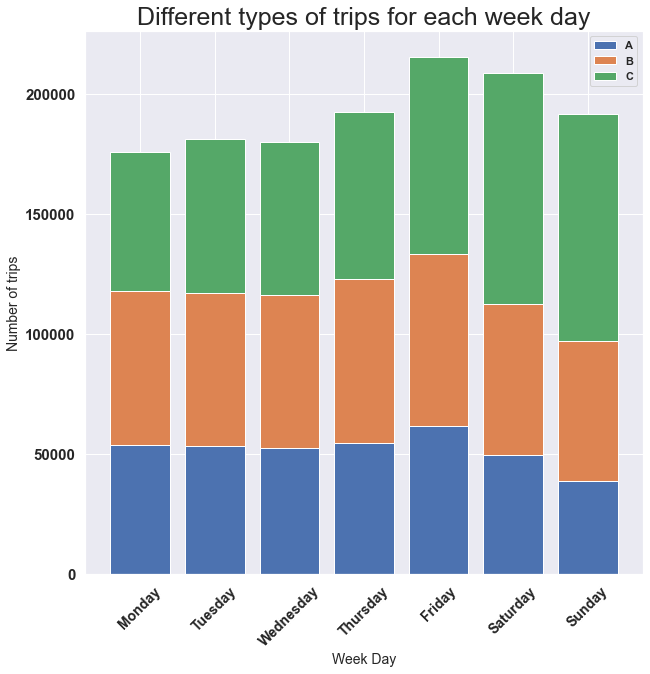

In [21]:
r = np.arange(7)
plt.figure(figsize=(10,10))
plt.rc('font', weight='bold')

p1 = plt.bar(unstack_call_type_df.index, unstack_call_type_df.TRIP_ID.A.values, label = 'A')
p2 = plt.bar(unstack_call_type_df.index, unstack_call_type_df.TRIP_ID.B.values, bottom=unstack_call_type_df.TRIP_ID.A.values, label = 'B')
p3 = plt.bar(unstack_call_type_df.index, unstack_call_type_df.TRIP_ID.C.values, bottom=unstack_call_type_df.TRIP_ID.B.values, label = 'C')

plt.xticks(r
           , values_week
           , rotation = 45
           , size = 14)
plt.xlabel('Week Day', size = 14)
plt.ylabel('Number of trips', size = 14)
plt.title('Different types of trips for each week day')

plt.legend()

plt.savefig('../../images/DVPPT/7type_week_day1.png')
plt.show()

In [270]:
pair_weekday_type = [list(z) for z in zip(unstack_call_type_df.TRIP_ID.A.values.tolist(),
                                     unstack_call_type_df.TRIP_ID.B.values.tolist(),
                                     unstack_call_type_df.TRIP_ID.C.values.tolist())]
pair_type_weekday = list(map(list, zip(*pair_weekday_type)))

bar = (
    Bar()
        .add_xaxis(["周一","周二","周三","周四","周五","周六","周日"])
        .add_yaxis("A", pair_type_weekday[0]
                  ,stack='stack1')
        .add_yaxis("B", pair_type_weekday[1]
                  ,stack='stack1')
        .add_yaxis("C", pair_type_weekday[2]
                  ,stack='stack1')
        .set_global_opts(title_opts=opts.TitleOpts(title="一周内平均每天不同类型行程数比较"),
                         xaxis_opts=opts.AxisOpts(name="一日",
                                                  name_location='middle',
                                                  name_gap=30)
                        ,yaxis_opts=opts.AxisOpts(name='行程数',
                                                  name_location='middle',
                                                  name_gap=60))
)

bar.render("../../html/DVPPT/7type_week_day1.html")
bar.render_notebook()

不是很清楚，因此决定换一种图

#### 三元组柱状图

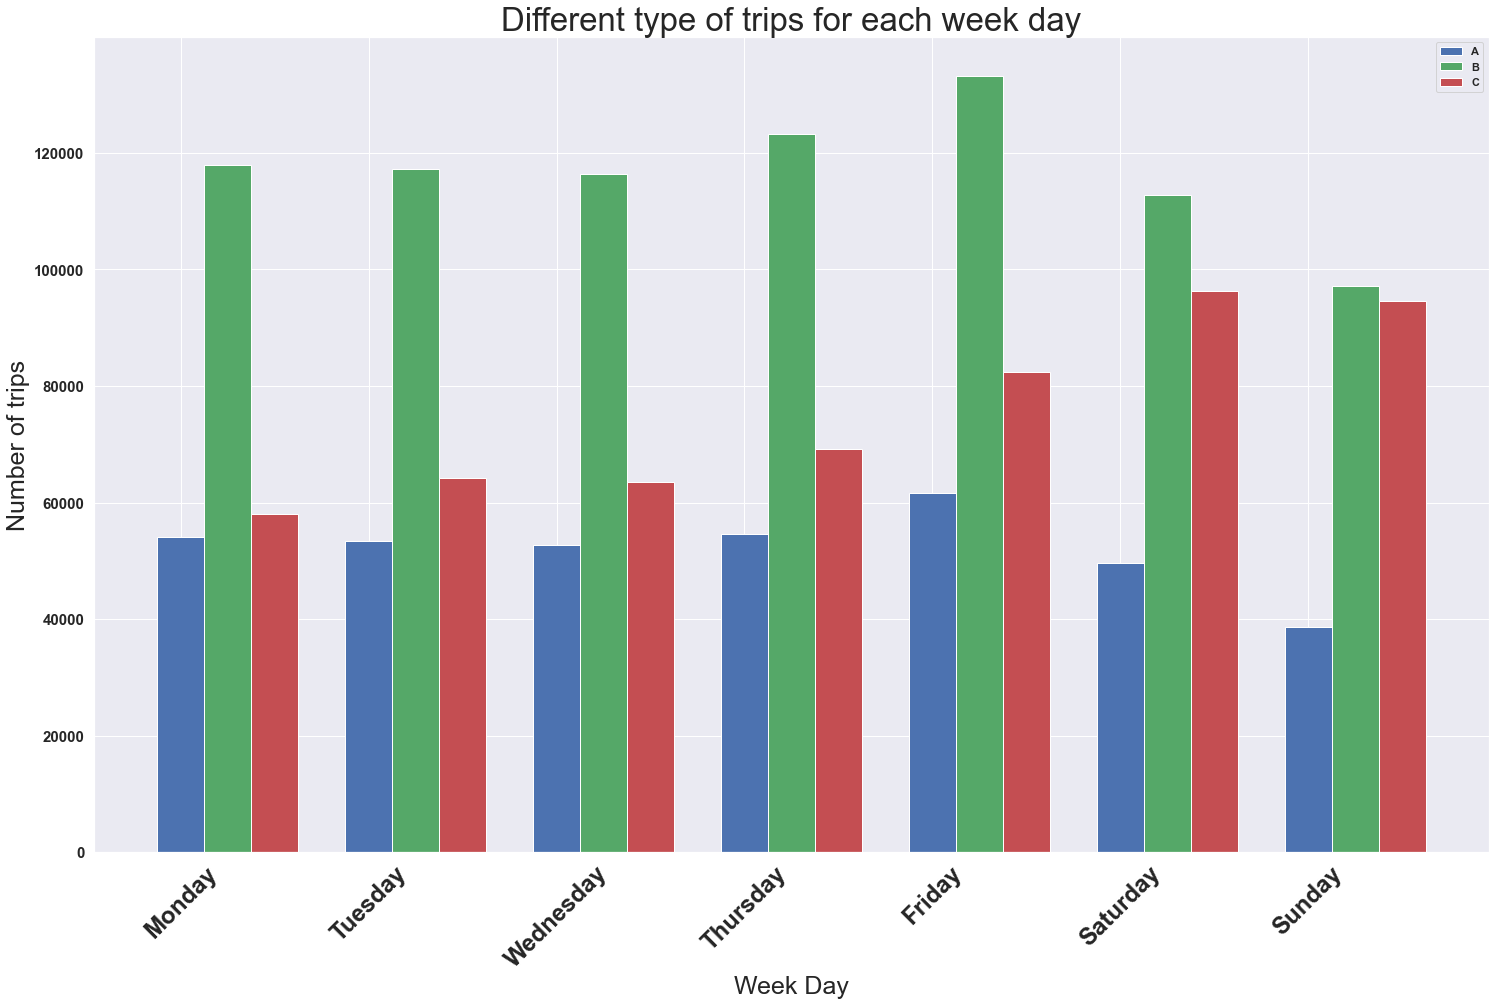

In [23]:
width = 0.25       # the width of the bars

plt.figure(figsize=(25,15))
plt.rc('font', size=25)          # controls default text sizes
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=17)
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

rects1 = plt.bar(unstack_call_type_df.index, unstack_call_type_df.TRIP_ID.A.values, width, color='b', label = 'A')
rects2 = plt.bar(unstack_call_type_df.index + width, unstack_call_type_df.TRIP_ID.B.values, width, color='g', label = 'B')
rects3 = plt.bar(unstack_call_type_df.index + (width*2), unstack_call_type_df.TRIP_ID.C.values, width, color='r', label = 'C')

plt.xticks(r
           , values_week
           , rotation = 45
           , size = 24)

plt.rc('font', weight='bold')
plt.xlabel('Week Day', size = 25)
plt.ylabel('Number of trips', size = 25)
plt.title('Different type of trips for each week day', size = 33)

plt.legend()

plt.savefig('../../images/DVPPT/8type_week_day2.png')
plt.show();

In [271]:
pair_weekday_type = [list(z) for z in zip(unstack_call_type_df.TRIP_ID.A.values.tolist(),
                                     unstack_call_type_df.TRIP_ID.B.values.tolist(),
                                     unstack_call_type_df.TRIP_ID.C.values.tolist())]
pair_type_weekday = list(map(list, zip(*pair_weekday_type)))

bar = (
    Bar()
        .add_xaxis(["周一","周二","周三","周四","周五","周六","周日"])
        .add_yaxis("A", pair_type_weekday[0])
        .add_yaxis("B", pair_type_weekday[1])
        .add_yaxis("C", pair_type_weekday[2])
        .set_global_opts(title_opts=opts.TitleOpts(title="一周内平均每天不同类型行程数比较"),
                         xaxis_opts=opts.AxisOpts(name="一日",
                                                  name_location='middle',
                                                  name_gap=30)
                        ,yaxis_opts=opts.AxisOpts(name='行程数',
                                                  name_location='middle',
                                                  name_gap=60))
)

bar.render("../../html/DVPPT/8type_week_day2.html")
bar.render_notebook()

可以明显看到A、B类都在周末最少，而C类反而在周末最多

# 包含行驶路线的数据分析
## 行程时长计算
每15s收集一次坐标，因此可以通过一次行程坐标的个数来算出每一趟打车的时间

In [25]:
miss_false_poly_source = source[source.MISSING_DATA == False]   #去除错误数据
miss_false_poly_source2 = miss_false_poly_source[miss_false_poly_source.POLYLINE != '[]']   #去除空路线
miss_false_polyline_source = miss_false_poly_source2[['TRIP_ID', 'CALL_TYPE', 'POLYLINE', 'TIMESTAMP']]
polyline_source = miss_false_polyline_source.copy()
polyline_source.reset_index(inplace=True)
polyline_source['PICK_UP_LOCATION'] = polyline_source.POLYLINE.apply(lambda x: eval(x.split()[0])[0])
polyline_source['PICK_UP_LOCATION'] = polyline_source.PICK_UP_LOCATION.apply(lambda x: np.flip(x,0))
polyline_source['DISTANCE'] = polyline_source.POLYLINE.apply(lambda x: int((x.count(',')+1)/2))
polyline_source['TIME_TRIP_MIN'] = polyline_source.DISTANCE.apply(lambda x: float((x-1)*15)/60)
polyline_source['WEEK_DAY'] = polyline_source.TIMESTAMP.apply(lambda x: dt.datetime.utcfromtimestamp(x).weekday())
polyline_source = polyline_source.loc[:, polyline_source.columns != 'index']
polyline_source.head()

,TRIP_ID,CALL_TYPE,POLYLINE,TIMESTAMP,PICK_UP_LOCATION,DISTANCE,TIME_TRIP_MIN,WEEK_DAY
0,1372636858620000589,C,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",1372636858,"[41.141412, -8.618643]",23,5.5,0
1,1372637303620000596,B,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",1372637303,"[41.159826, -8.639847]",19,4.5,0
2,1372636951620000320,C,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",1372636951,"[41.140359, -8.612964]",65,16.0,0
3,1372636854620000520,C,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",1372636854,"[41.151951, -8.574678]",43,10.5,0
4,1372637091620000337,C,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",1372637091,"[41.18049, -8.645994]",29,7.0,0


## 导出计算后数据

In [26]:
polyline_source.to_csv('newSource/polyline_source.csv')

## 行程时长统计

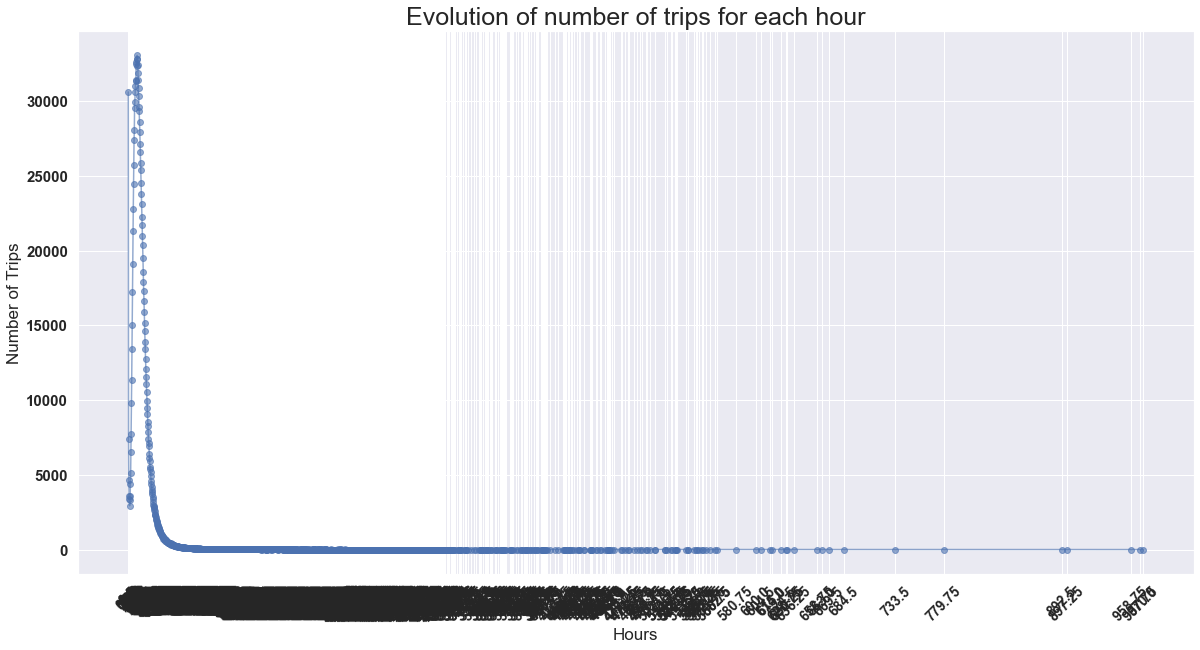

In [27]:
time_trip_min_plot = pd.DataFrame({
    'value': polyline_source.TIME_TRIP_MIN.value_counts().values
    , 'min': polyline_source.TIME_TRIP_MIN.value_counts().keys()})
#time_plot.set_index('date', inplace=True)
time_trip_min_plot = time_trip_min_plot.set_index('min')['value']
time_trip_min_plot.sort_index(inplace=True)
time_trip_min_plot.keys().astype("int")

# Plotting
plt.figure(figsize=(20,10))
plt.rc('font', size=25)          # controls default text sizes
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

plt.xticks(polyline_source.TIME_TRIP_MIN.value_counts().keys()
           , polyline_source.TIME_TRIP_MIN.value_counts().keys()
           , rotation = 45
           , size = 14)

plt.xlabel('Hours')
plt.ylabel('Number of Trips')
plt.title('Evolution of number of trips for each hour')

plt.plot_date(time_trip_min_plot.keys(), time_trip_min_plot.values, 'bo-', alpha=0.6)

plt.savefig('../../images/DVPPT/9trip_len.png')
plt.show();

由于实在是太不直观了，~~奇奇怪怪~~ 因此选择区间统计
## 行程时长区间统计
### 区间统计数据

In [197]:
polyline_df = polyline_source[['TIME_TRIP_MIN','TRIP_ID']]
polyline_bin_df = pd.cut(polyline_df['TIME_TRIP_MIN'],
                         bins=[0, 5, 10, 15, 30, 1000],
                         right=False,
                         labels=['0~5','5~10','10~15','15~30','30~'])
new_polyline_df = pd.value_counts(polyline_bin_df).sort_index(axis=0)
new_polyline_df

0~5      213059
5~10     612135
10~15    480659
15~30    344932
30~       53974
Name: TIME_TRIP_MIN, dtype: int64

### 区间统计直方图

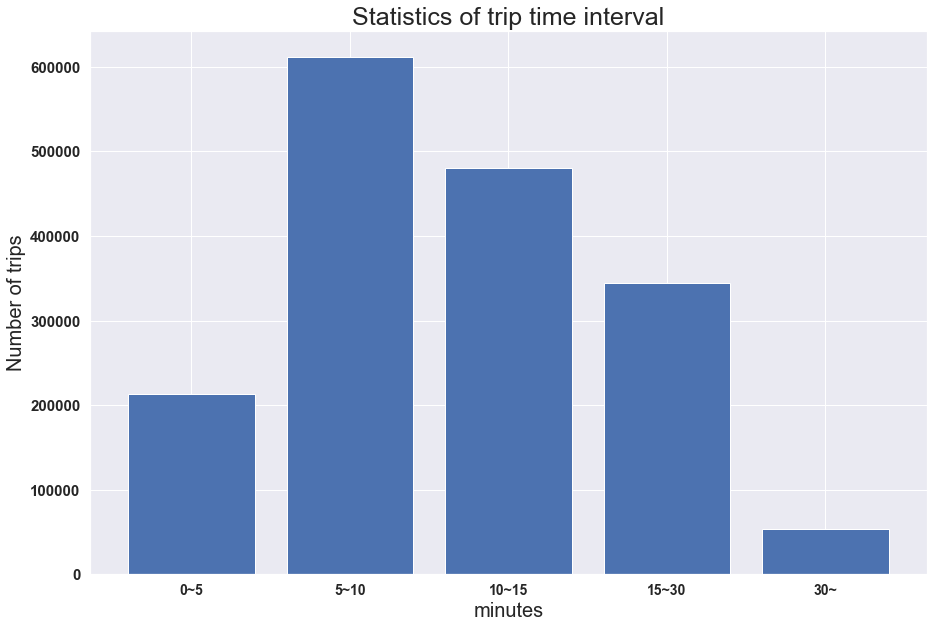

In [187]:
plt.figure(figsize=(15,10))
my_colors = 'b'

ax = plt.bar(new_polyline_df.keys()
             , new_polyline_df.values
             , color = my_colors)

plt.xticks(new_polyline_df.keys()
           , new_polyline_df.keys()
           , size = 14)
plt.xlabel('minutes', size = 20)
plt.ylabel('Number of trips', size = 20)
plt.title('Statistics of trip time interval', size = 25)

plt.savefig('../../images/DVPPT/10trip_interval1.png')
plt.show()

In [188]:
bar = (
    Bar()
        .add_xaxis(new_polyline_df.keys().tolist())
        .add_yaxis("", new_polyline_df.values.tolist())
        .set_global_opts(title_opts=opts.TitleOpts(title="行程时长区间统计"),
                         xaxis_opts=opts.AxisOpts(name="分钟",
                                                  name_location='middle',
                                                  name_gap=30)
                        ,yaxis_opts=opts.AxisOpts(name='行程数',
                                                  name_location='middle',
                                                  name_gap=60))
        .set_colors("#4C72B0")
)

bar.render("../../html/DVPPT/10trip_interval1.html")
bar.render_notebook()

感觉用饼图会更直观一点，因此加入饼图

### 区间统计饼图

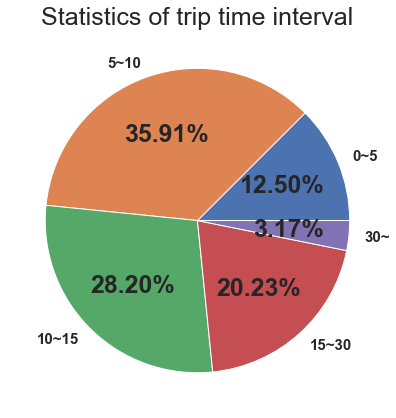

In [210]:
plt.figure(figsize=(7,7))
plt.rc('font', size=25)          # controls default text sizes
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.pie(new_polyline_df.values
        , labels=new_polyline_df.keys()
        , autopct='%1.2f%%')
plt.title('Statistics of trip time interval')

plt.savefig('../../images/DVPPT/11trip_interval2.png')
plt.show()

In [238]:
keys_triptime = new_polyline_df.keys().tolist()
values_triptime = new_polyline_df.values.tolist()

pie = (
    Pie()
    .add(
        "",
        [list(z) for z in zip(keys_triptime, values_triptime)]
        #, radius=["30%", "60%"], rosetype="radius"  # 玫瑰图
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="行程时长区间统计"))  # 标题
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))  # 数据标签设置
)

pie.render("../../html/DVPPT/11trip_interval2.html")
pie.render_notebook()

大部分形成都集中在5\~15分钟内。可见 ~~葡萄牙很小~~ ~~大家都是懒狗~~ 行程时间都在中短程。

## 工作日与休息日行程时长比较

In [212]:
triptime_df = polyline_source[['TIME_TRIP_MIN','TRIP_ID','WEEK_DAY']]
triptime_weekday_df = triptime_df[triptime_df.WEEK_DAY < 5]
triptime_weekend_df = triptime_df[triptime_df.WEEK_DAY >= 5]
triptime_weekend_df

,TIME_TRIP_MIN,TRIP_ID,WEEK_DAY
24564,6.50,1373069094620000467,5
24567,7.00,1373068918620000370,5
24578,8.00,1373069217620000353,5
24595,14.50,1373069033620000343,5
24597,12.25,1373068920620000688,5
...,...,...,...
1704721,11.00,1404020381620000510,6
1704736,7.50,1401596832620000609,6
1704745,3.00,1403935197620000205,5
1704748,4.00,1404014448620000407,6


### 工作日数据

In [214]:
triptime_weekday_bin_df = pd.cut(triptime_weekday_df['TIME_TRIP_MIN'],
                         bins=[0, 5, 10, 15, 30, 1000],
                         right=False,
                         labels=['0~5','5~10','10~15','15~30','30~'])
weekday_df = pd.value_counts(triptime_weekday_bin_df).sort_index(axis=0)
weekday_df

0~5      143972
5~10     416854
10~15    346551
15~30    266159
30~       43638
Name: TIME_TRIP_MIN, dtype: int64

### 休息日数据

In [215]:
triptime_weekend_bin_df = pd.cut(triptime_weekend_df['TIME_TRIP_MIN'],
                         bins=[0, 5, 10, 15, 30, 1000],
                         right=False,
                         labels=['0~5','5~10','10~15','15~30','30~'])
weekend_df = pd.value_counts(triptime_weekend_bin_df).sort_index(axis=0)
weekend_df

0~5       69087
5~10     195281
10~15    134108
15~30     78773
30~       10336
Name: TIME_TRIP_MIN, dtype: int64

### 作图比较

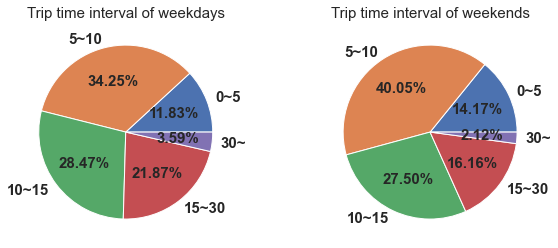

<Figure size 504x504 with 0 Axes>

In [268]:
fig = plt.figure(figsize=(10,4))

plt.figure(figsize=(7,7))
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

ax1 = fig.add_subplot(121)
ax1.pie(weekday_df.values
        , labels=weekday_df.keys()
        , autopct='%1.2f%%')
ax1.set_title('Trip time interval of weekdays', size = 15)

ax2 = fig.add_subplot(122)
ax2.pie(weekend_df.values
        , labels=weekend_df.keys()
        , autopct='%1.2f%%')
ax2.set_title('Trip time interval of weekends', size = 15)

fig.savefig('../../images/DVPPT/12trip_comp.png')
#plt.show()

In [266]:
keys_triptime_weekday = weekday_df.keys().tolist()
values_triptime_weekday = weekday_df.values.tolist()
keys_triptime_weekend = weekend_df.keys().tolist()
values_triptime_weekend = weekend_df.values.tolist()

pie = (
    Pie()
    .add(
        "",
        [list(z) for z in zip(keys_triptime_weekday, values_triptime_weekday)],
        center=["28%", "50%"],
        radius=["30%", "60%"],
        rosetype="radius"
    )
    .add(
        "",
        [list(z) for z in zip(keys_triptime_weekend, values_triptime_weekend)],
        center=["72%", "50%"],
        radius=["30%", "60%"],
        rosetype="radius"
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="工作日与休息日行程时长比较",
                                              subtitle="左：工作日；右：休息日"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))  # 数据标签设置
)

pie.render("../../html/DVPPT/12trip_comp.html")
pie.render_notebook()

休息日的0\~10分钟行程比例更大了，说明周末的临时起意行程比例更大。